In [ ]:
from os.path import exists
from os import mkdir
from os.path import join
from PIL import Image
import json


import tensorflow as tf
import threading
import numpy as np
import h5py

from scipy.misc import imread, imresize

from utils import load_vocab
from time import time
import datetime

def load_images(ps):
    tic = time()
    images = [imread(p,mode='RGB') for p in ps]
    toc = time()
    print("imread = %1.3fs" % (toc-tic))
    treated_images = []
    sizes = []
    for img in images:
        sizes.append(img.shape[:2])
        treated_img = imresize(img,(448,448),'nearest') / 255.0
        treated_images.append(treated_img)
    tic = time()
    print("Resize / scaling = %1.3fs" % (tic-toc))
    return treated_images,sizes


class Dataset(object):
    def __init__(self,h5_path,image_paths,max_q=None,max_mc=None,N=None):
        self.h5 = h5py.File(h5_path,mode='r')
        self.image_ids = self.h5['image_ids'].value[:N]
        self.questions = self.h5['questions'].value[:N]
        self.multiple_choice = self.h5['multiple_choices'].value[:N]
        self.answers = self.h5['ground_truth'].value[:N]
        self.N = len(self.image_ids)
        if max_q:
            if max_q<self.questions.shape[1]:
                self.questions = self.questions[:,:max_q]
            else:
                self.questions = np.pad(self.questions,
                                        ((0,0),(0,max_q-self.questions.shape[-1])),
                                        'constant',constant_values=w2i['</s>'])
        if max_mc:
            if max_mc<self.multiple_choice.shape[-1]:
                self.multiple_choice = self.multiple_choice[:,:,max_mc]
            else:
                self.multiple_choice = np.pad(self.multiple_choice,
                                              ((0,0),(0,0),(0,max_mc-self.multiple_choice.shape[-1])),
                                              'constant',constant_values=w2i['</s>'])
        self.max_mc = self.multiple_choice.shape[1]
        self.max_q = self.questions.shape[1]
        self.indexes = np.arange(self.N)
        self.image_paths = image_paths
        
    def __iter__(self):
        return self

    def batch_gen(self,batch_size=64,shuffle=True):
        def load_image(p):
            img = imread(p,mode='RGB')
            size = img.shape[:2]
            img = imresize(img,(224,224),'nearest') / 255.0
            return img,size
        
        if shuffle:
            np.random.shuffle(self.indexes)
        n_batches = self.N // batch_size
        load_time = 0
        for batch_id in range(n_batches):
            begin = batch_id*batch_size
            end = min((batch_id+1)*batch_size, self.N)
            idxs = self.indexes[begin:end]
            image_ids = self.image_ids[idxs]
            images,sizes = [],[]
            for i in image_ids:
                p = self.image_paths[i]
                img,size = load_image(p)
                images.append(img)
                sizes.append(size)
            images = np.stack(images)
            sizes = np.array(sizes)
            questions = self.questions[idxs]
            lengths = np.sum(np.not_equal(questions, 
                                          w2i['</s>']), 
                             axis=1)
            question_mask = np.zeros((self.max_q,batch_size))
            for i,q in enumerate(questions):
                question_mask[lengths[i]-1,i] = 1
            answers = self.answers[idxs][:,:,:self.max_mc]
            multiple_choice = self.multiple_choice[idxs]
            S = []
            for m,a in zip(multiple_choice,answers):
                s = [np.mean((x==a).prod(axis=1)) for x in m]
                S.append(s)
            S = np.array(S)
            answers = np.zeros((answers.shape[0],self.multiple_choice.shape[1]))
            answers[np.arange(answers.shape[0]),np.argmax(S,axis=1)] = 1
            yield (images,questions,question_mask,answers,S,multiple_choice,sizes)

def test():
    accuracy = 0.
    total_time = 0
    n_batches = val_set.N//batch_size
    t = threading.Thread(target=load_and_enqueue,args=(sess,enqueue_op,False,val_set))
    t.start()
    for idx in range(n_batches):
        tic = time()
        y_pred,answers = sess.run([out_probas,Pl['answers']])
        y_pred = np.argmax(y_pred,axis=1)
        accuracy += np.sum(answers[np.arange(batch_size),y_pred])
        step_time = time()-tic
        total_time += step_time
        eta = total_time*(n_batches-idx)/(idx+1)
        print("\tTest: %d/%d - accuracy = %1.3f -  ETA = %s" % (idx,
                                                                val_set.N/batch_size,
                                                                accuracy/(batch_size*(idx+1)),
                                                                datetime.timedelta(seconds=int(eta))))
    return accuracy / (batch_size*(idx+1))

def load_and_enqueue(sess,enqueue_op,shuffle,dataset):
    batch_gen = dataset.batch_gen(batch_size,shuffle)
    for (images,questions,question_mask,answers,S,multiple_choice,sizes) in batch_gen:
        feed_dict = {Ql['images']:images,
                     Ql['questions']:questions,
                     Ql['question_mask']:question_mask, 
                     Ql['answers']:answers,
                     Ql['scores']:S,
                     Ql['mc']:multiple_choice}
        sess.run(enqueue_op,feed_dict=feed_dict)

image_paths = {}
root_path = "/srv/data/datasets/mscoco/images/"

for split in 'train val'.split():
    image_ids_path = "datasets/vqa/"+split+"/img_ids.txt"
    image_ids = set([int(x.strip()) for x in open(image_ids_path).readlines()])
    print(split,len(image_ids))
    for x in image_ids:
        name = 'COCO_'+split+'2014_'+format(x, '012')+'.jpg'
        path = join(root_path,split+"2014",name)
        image_paths[x] = path  
i2w, w2i = load_vocab('datasets/vqa/vocabulary.txt')

train_set = Dataset('datasets/vqa/train/dataset_cleaner.h5',
                    image_paths,N=None)
max_mc = train_set.multiple_choice.shape[-1]
max_q = train_set.max_q
val_set = Dataset('datasets/vqa/val/dataset_cleaner.h5',
                  image_paths,max_q=max_q,max_mc=max_mc,N=64)

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.misc import imread

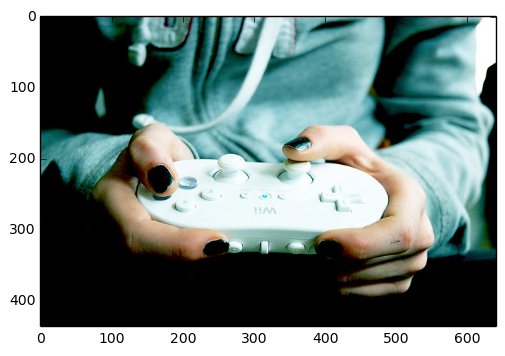

what do you call the controller the girl is using ? </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
no </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
blue </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
yard </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
yard </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
3 </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
4 </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
wii </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
white </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
yard yard </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>
wii - yard </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> 

In [16]:
i = 500
plt.imshow(imread(image_paths[train_set.image_ids[i]]))
plt.show()
print(" ".join(i2w[x] for x in train_set.questions[i]))
for m in train_set.multiple_choice[i]:
    print(" ".join(i2w[x] for x in m))

In [17]:
w2i['yard']

255

In [45]:
batch_size = 32
#di = 5096
#datt = 300
dv = 5096
dh = 1024
dmult = 2048
d1 = 2048
demb = 300
model_name = "marginloss_wholeimage_test"

Nvocab = len(i2w)

tf.reset_default_graph()
# Read the model
with open("tensorflow-vgg16/vgg16.tfmodel",
          mode='rb') as f:
    fileContent = f.read()
graph_def = tf.GraphDef()
# Put it into my graph_def
graph_def.ParseFromString(fileContent)
graph = tf.get_default_graph()

Nq = train_set.N

Ql = {}
Ql['images'] = tf.placeholder(tf.float32, 
                              [batch_size, 224, 224, 3],
                              name="images") #batch x width x height x channels
Ql['questions'] = tf.placeholder(tf.int32, 
                                 [batch_size, max_q],
                                 name="question")
Ql['question_mask'] = tf.placeholder(tf.int32,
                                     [max_q, None],
                                     name="question_mask")
Ql['mc'] = tf.placeholder(tf.int32,
                          [batch_size, 18,None], 
                          name="mc")
Ql['answers'] = tf.placeholder(tf.float32, 
                               [batch_size,18], 
                               name="answers")
Ql['scores'] = tf.placeholder(tf.float32,
                              [batch_size,18],
                              name="scores")

q = tf.FIFOQueue(500, [tf.float32,tf.int32, tf.int32, 
                      tf.int32, tf.float32, tf.float32], shapes=[[batch_size,224,224,3],
                                                                 [batch_size,max_q],
                                                                 [max_q,batch_size],
                                                                 [batch_size,18,max_mc],
                                                                 [batch_size,18],
                                                                 [batch_size,18]])

enqueue_op = q.enqueue([Ql['images'], Ql['questions'], 
                        Ql['question_mask'], Ql['mc'], 
                        Ql['answers'], Ql['scores']])
Pl = {}
Pl['images'], Pl['questions'], Pl['question_mask'], Pl['mc'], Pl['answers'], Pl['scores'] = q.dequeue()


#with tf.variable_scope('image'):
#    tf.get_variable('W', shape=[di, dv],
#                    initializer=tf.contrib.layers.xavier_initializer())
#    tf.get_variable(name='b',
#                    initializer=tf.zeros([dv]))

with tf.variable_scope('embedding'):
    tf.get_variable('W',
                    initializer=tf.random_uniform([Nvocab, demb], -0.1, 0.1))

#with tf.variable_scope('multiple_choice'):
#    tf.get_variable('emb',
#                    initializer=tf.random_uniform([Na, dans], -0.1, 0.1))

with tf.variable_scope('multimodal'):
    tf.get_variable('Wv', 
                    shape = [dv,dmult], 
                    initializer=tf.contrib.layers.xavier_initializer())
    tf.get_variable(name='bv',
                    initializer=tf.zeros([dmult]))
    tf.get_variable('Wq', 
                    shape = [dh,dmult], 
                    initializer=tf.contrib.layers.xavier_initializer())
    tf.get_variable(name='bq',
                    initializer=tf.zeros([dmult]))

with tf.variable_scope('multimodal_to_ans'):
    tf.get_variable('W1',
                    shape=[dmult,d1],
                    initializer=tf.contrib.layers.xavier_initializer())
    tf.get_variable('b1',
                    initializer=tf.zeros([d1]))
    tf.get_variable('W2',
                    shape=[d1,demb],
                    initializer=tf.contrib.layers.xavier_initializer())
    tf.get_variable('b2',
                    initializer=tf.zeros([demb]))

#recurrent = tf.nn.rnn_cell.GRUCell(dh)
recurrent = tf.nn.rnn_cell.LSTMCell(dh)

def merge_modalities(V,q_out):
    with tf.variable_scope('multimodal',reuse=True):
        Wv = tf.get_variable('Wv')
        Wq = tf.get_variable('Wq')
        bv = tf.get_variable('bv')
        bq = tf.get_variable('bq')

        xv = tf.nn.relu(tf.nn.xw_plus_b(V,Wv,bv))
        xq = tf.nn.relu(tf.nn.xw_plus_b(q_out,Wq,bq))

        x = tf.nn.relu(xv*xq)
        return x

def multimodal_to_ans(x):
    with tf.variable_scope('multimodal_to_ans',reuse=True):
        W1 = tf.get_variable('W1')
        b1 = tf.get_variable('b1')
        W2 = tf.get_variable('W2')
        b2 = tf.get_variable('b2')
        x1 = tf.nn.relu(tf.nn.xw_plus_b(x,W1,b1))
        x2 = tf.nn.relu(tf.nn.xw_plus_b(x1,W2,b2))
    return x2

tf.import_graph_def(graph_def, 
                    input_map={'images':Pl['images']})

out_tensor1 = graph.get_tensor_by_name("import/Relu_1:0")
out_tensor2 = graph.get_tensor_by_name("import/fc8/BiasAdd:0")
out_tensor = tf.concat(1,[out_tensor1,out_tensor2])
V = out_tensor

state = recurrent.zero_state(batch_size, tf.float32)
states = []
q_out = []
with tf.variable_scope('embedding',reuse=True):
    emb = tf.get_variable('W')
for j in range(max_q):
    question_emb = tf.nn.embedding_lookup(emb, Pl['questions'][:,j])
    if j>0:
        tf.get_variable_scope().reuse_variables()
    output,state = recurrent(question_emb, state)
    states.append(state)
    q_out.append(output)
q_out = tf.pack(q_out)
q_out = tf.reduce_sum(tf.mul(q_out, 
                             tf.to_float(tf.expand_dims(Pl['question_mask'],-1))),0)

x = merge_modalities(V,q_out)
x = multimodal_to_ans(x)
mc_mask = tf.to_float(tf.not_equal(Pl['mc'],w2i['</s>']))
norm_mask = tf.expand_dims(tf.reduce_sum(mc_mask,reduction_indices=2),-1)
mc_emb = tf.nn.embedding_lookup(emb, Pl['mc'])
masked_mc_out = tf.mul(tf.expand_dims(mc_mask,-1),mc_emb)
mc_out = tf.reduce_sum(masked_mc_out,reduction_indices=2)/norm_mask

out_scores = tf.batch_matmul(mc_out,tf.expand_dims(x,1),adj_y=True)[:,:,0]
out_probas = tf.nn.softmax(out_scores)

#normalized_ans = Pl['answers'] / tf.expand_dims(tf.reduce_sum(Pl['answers'],reduction_indices=1),-1)
#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(out_scores,normalized_ans)

prob_min_score = out_probas - Pl['scores']
positive_score = tf.reduce_sum( prob_min_score * Pl['answers'],reduction_indices=1)
positive_score = tf.expand_dims(positive_score,1)
margin_matrix = prob_min_score * (1-Pl['answers']) - positive_score
margin = tf.maximum(tf.to_float(0),
                    tf.reduce_max(margin_matrix, 
                                  reduction_indices=1))
cost = tf.reduce_mean(margin)

#optimizer = tf.train.AdadeltaOptimizer(0.1)
optimizer = tf.train.AdamOptimizer()
#optimizer = tf.train.GradientDescentOptimizer(0.01)
gvs = optimizer.compute_gradients(cost)
# with tf.device('/cpu:0'):
cost_s = tf.scalar_summary('train loss', cost, name='train_loss')
#capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad,var in gvs]
capped_gvs = [(grad, var) for grad,var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)

model_rootpath = "/home/hbenyounes/vqa/results/vqa/"
model_path = join(model_rootpath,model_name)
if not exists(model_path):
    mkdir(model_path)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True,
                                        gpu_options=gpu_options))

writer = tf.train.SummaryWriter(join(model_path,'tf_log'), sess.graph)
saver = tf.train.Saver(max_to_keep=100)
sess.run(tf.initialize_all_variables())

In [46]:
n_batches = train_set.N//batch_size
n_epochs = 50
output_file = open(join(model_path,"output.txt"),'w')
best_test_acc = -1
break_all = False
for epoch in range(1,n_epochs+1):
    t = threading.Thread(target=load_and_enqueue,args=(sess,enqueue_op,True,train_set))
    t.start()
    epoch_loss = []
    total_tic = time()
    train_accuracy = 0.
    for idx in range(n_batches):
        step = idx + (epoch-1)*n_batches
        tic = time()
        _,loss_value,loss_s,y_pred,ans = sess.run([train_op,cost,
                                                   cost_s,out_probas,
                                                   Pl['answers']])
        writer.add_summary(loss_s,step)
        toc = time()
        step_time = toc - tic
        total_time = toc - total_tic
        eta = total_time*(n_batches-idx)/(idx+1)
        y_pred = y_pred.argmax(axis=1)
        train_accuracy += np.sum(ans[np.arange(batch_size),y_pred])
        print("Epoch %d/%d - batch %d/%d - loss = %1.3f - accuracy = %1.3f - " \
        "elapsed = %1s - ETA = %s" % (epoch,n_epochs,
                                          idx,n_batches,
                                          loss_value,train_accuracy/(batch_size*(idx+1)),
                                          str(datetime.timedelta(seconds=int(total_time))),
                                          str(datetime.timedelta(seconds=int(eta)))))
        epoch_loss.append(loss_value)
        if np.isnan(loss_value):
            print("Loss is nan, i get out")
            
            break_all = True
        if break_all:
            break
    if break_all:
        break
    train_accuracy = train_accuracy / (batch_size*(idx+1))
    train_loss = np.mean(epoch_loss)

Epoch 1/50 - batch 0/1 - loss = 0.754 - accuracy = 0.094 - elapsed = 0:00:03 - ETA = 0:00:03
Epoch 2/50 - batch 0/1 - loss = 0.756 - accuracy = 0.375 - elapsed = 0:00:00 - ETA = 0:00:00
Epoch 3/50 - batch 0/1 - loss = 0.753 - accuracy = 0.438 - elapsed = 0:00:00 - ETA = 0:00:00
Epoch 4/50 - batch 0/1 - loss = 0.746 - accuracy = 0.719 - elapsed = 0:00:00 - ETA = 0:00:00
Epoch 5/50 - batch 0/1 - loss = 0.719 - accuracy = 0.719 - elapsed = 0:00:01 - ETA = 0:00:01
Epoch 6/50 - batch 0/1 - loss = 0.676 - accuracy = 0.719 - elapsed = 0:00:00 - ETA = 0:00:00
Epoch 7/50 - batch 0/1 - loss = 0.574 - accuracy = 0.812 - elapsed = 0:00:00 - ETA = 0:00:00
Epoch 8/50 - batch 0/1 - loss = 0.535 - accuracy = 0.719 - elapsed = 0:00:00 - ETA = 0:00:00
Epoch 9/50 - batch 0/1 - loss = 0.395 - accuracy = 0.844 - elapsed = 0:00:00 - ETA = 0:00:00
Epoch 10/50 - batch 0/1 - loss = 0.407 - accuracy = 0.812 - elapsed = 0:00:00 - ETA = 0:00:00
Epoch 11/50 - batch 0/1 - loss = 0.389 - accuracy = 0.812 - elapsed =